In [1]:
import cv2
import numpy as np
import time
from PIL import Image, ImageTk
import json
import matplotlib.pyplot as plt

In [2]:
# ham xu lu canh
def edge_processing(image_e):  # dau vao la 1 cai anh
    image_edge = image_e[200:730, 100:950]  # cat anh, lay truc y tu 0 toi pixel 730, trục x lay tu 70 toi 950. why ? dont ask me :)
    
    plt.imshow(image_edge)
    plt.show()
    
    img_gr = cv2.cvtColor(image_edge, cv2.COLOR_BGR2GRAY);  # chuyen doi sang anh xam

    #cv2.imwrite('gray.jpg', img_gr)  # luu cai anh xam nay lai de coi cho dui
    plt.imshow(img_gr)

    img_remove_noise = cv2.GaussianBlur(img_gr, (5, 5), 0);  # lam mo anh,giam nhieu
    # _,img_2=cv2.threshold(img_remove_noise,20,255,cv2.THRESH_BINARY)
    img_canny = cv2.Canny(img_remove_noise, 5, 30);  # tim vien cua doi tuong
    kernel = np.ones((9, 9), np.uint8)  # tao kernel de lam day bien
    img_bien = cv2.dilate(img_canny, kernel, iterations=1)  # lamdaybien
    contours, _ = cv2.findContours(img_bien, cv2.RETR_LIST,
                                      cv2.CHAIN_APPROX_NONE)  # tim mot doi tuong co vien trang tren nen den
    # cv2.imwrite('img_bien.jpg',img_bien)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]  # ghi lai thu tu contour
    contour = contours[1]  # lay coutour 1
    # c=max(contours,key=cv2.contourArea)

    # contour=max(contours,key=cv2.contourArea)
    # ve ra coi cho dui
    cv2.drawContours(image_edge, contour, -1, 255, 3)
    cv2.drawContours(image_edge, contour, -1, 255, 3)
    cv2.imwrite('edge.jpg', image_edge)
    cv2.imwrite('bien.jpg', img_bien)
    cv2.imwrite('canny.jpg', img_canny)

    S = cv2.contourArea(contour)  # tinh dien tich cai contour do

    return contour, S  # tra ve contour va dien tich cua no

In [18]:
# xu ly mau sac
def color_processing(image_c):  # dau vao la 1 tam hinh
    color = 'none'
    hsv_img = cv2.cvtColor(image_c, cv2.COLOR_BGR2HSV)  # doc cai hinh do duoi he mau HSV

    ####cac gia tri mau sac###
    lower_red = np.array([160, 100, 20])
    upper_red = np.array([180, 255, 255])

    lower_orange = np.array([10, 60, 100])
    upper_orange = np.array([32, 255, 255])

    lower_green = np.array([70  , 65 , 33])
    upper_green = np.array([100 , 255, 255])

    # tao mask cho  3 mau
    mask_red = cv2.inRange(hsv_img, lower_red, upper_red)
    mask_orange = cv2.inRange(hsv_img, lower_orange, upper_orange)
    mask_green = cv2.inRange(hsv_img, lower_green, upper_green)
    ###lam day mang mau##
    kernel = np.ones((5, 5), np.uint8)
    mask_red = cv2.dilate(mask_red, kernel, iterations=1)
    mask_orange = cv2.dilate(mask_orange, kernel, iterations=1)
    mask_green = cv2.dilate(mask_green, kernel, iterations=1)

    img_red = cv2.bitwise_and(image_c, image_c, mask=mask_red)
    img_orange = cv2.bitwise_and(image_c, image_c, mask=mask_orange)
    img_green = cv2.bitwise_and(image_c, image_c, mask=mask_green)
    ####tinh so luong pixel moi mau
    amount_red = cv2.countNonZero(mask_red)
    amount_orange = cv2.countNonZero(mask_orange)
    amount_green = cv2.countNonZero(mask_green)
    amount_3colors = amount_red + amount_orange + amount_green + 1
    p_red = amount_red / amount_3colors
    p_orange = amount_orange / amount_3colors
    p_green = amount_green / amount_3colors
    if p_red > 0.8:
        color = 'red'
    elif p_orange > 0.2:
        color = 'orange'
    elif p_green > 0.6:
        color = 'green'

    print('color {}'.format(color))
    print('red {}'.format(p_red))
    print('orange {}'.format(p_orange))
    print('green {}'.format(p_green))

    return color, img_red, img_orange, img_green

In [4]:
def phanloai(S, red_tc, orange_tc, green_tc, data_js): #dau vao la dien tich, gia tri do cam xanh (0 hoac 1)
    tomato = 'none'
    for tp in data_js: #voi moi gia tri trong datta_js, goi do la tp
        if tp != 'Amount': #neu tp khac Amount (co nghi la tp la type 1 2 3)
            if (S >= int(data_js[tp]['min']) and S < int(data_js[tp]['max']) #so sanh neu dien tich lon hon hoac bang min va be hon max
                    and red_tc == int(data_js[tp]['RED']) #va gia tri mau duoc tra ve co giong gia tri mau duoc quy dinh tren server hay khong
                    and orange_tc == int(data_js[tp]['ORANGE'])  #data_js[tp]['ORANGE'] la 1 = true hoac 0 = false,
                    and green_tc == int(data_js[tp]['GREEN'])):
                tomato = str(tp) #neu dieu kien dung het thi chon loai do
    if tomato == 'none':
        tomato = 'Type_4' #neu khong thoa dieu kien tren thi la loai 4
    
    print('Tomato loai: {}'.format(tomato))
    return tomato  # tra ve loai ca chua type 1 2 3 4 'Type_1'


In [5]:
f = open('database.json')
data = json.load(f)


In [21]:
red_tc = 0
orange_tc = 0
green_tc = 0

image_ori = cv2.imread('getimg/hoacam13.jpg') #chup anh trai ca chua

plt.imshow(image_ori)
plt.show()

contour, S = edge_processing(image_ori) #lay ra vien ca chua va dienj tich
S = S / 1000
print("Square = {}".format(S))

if S < 12: #dien tich nho qua thi chac khong phai trai ca chua ? :D
    print('Squre less than 12')

else:
    color, red, orange, green = color_processing(image_ori)
        #xu ly mau, tra ve gia tri vi du: red, anh nhung phan mau do, anh nhung phan mau cam, anh nhung phan mau xanh

    if color == 'red': #neu trai ca chua sau khi xu ly anh tra ve mau do
        red_tc = 1 #set gia tri do bang 1, cac gia tri mau khac bang 0
        orange_tc = 0
        green_tc = 0
    else:
        if color == 'orange':
            red_tc = 0
            orange_tc = 1
            green_tc = 0
        else:
            if color == 'green':
                red_tc = 0
                orange_tc = 0
                green_tc = 1
    print(red_tc, orange_tc, green_tc)

    tomato_nha = phanloai(S, red_tc, orange_tc, green_tc, data) #dua vo cai ham phan loai de phan loai


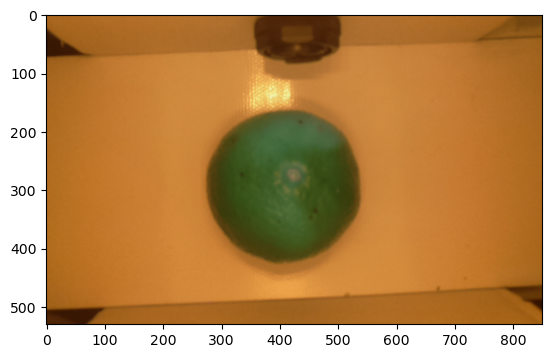

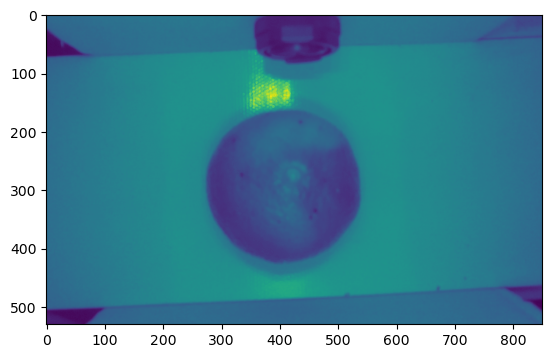

In [21]:
if (True):
    image_e = cv2.imread('getimg/hoaxanh1.jpg') #chup anh trai ca chua
    image_edge = image_e[200:730, 100:950]  # cat anh, lay truc y tu 0 toi pixel 730, trục x lay tu 70 toi 950. why ? dont ask me :)
    
    plt.imshow(image_edge)
    plt.show()
    
    img_gr = cv2.cvtColor(image_edge, cv2.COLOR_BGR2GRAY);  # chuyen doi sang anh xam

    #cv2.imwrite('gray.jpg', img_gr)  # luu cai anh xam nay lai de coi cho dui
    plt.imshow(img_gr)
    plt.show()

    img_remove_noise = cv2.GaussianBlur(img_gr, (5, 5), 0);  # lam mo anh,giam nhieu
    # _,img_2=cv2.threshold(img_remove_noise,20,255,cv2.THRESH_BINARY)
    img_canny = cv2.Canny(img_remove_noise, 30, 30);  # tim vien cua doi tuong
    kernel = np.ones((9, 9), np.uint8)  # tao kernel de lam day bien
    img_bien = cv2.dilate(img_canny, kernel, iterations=1)  # lamdaybien
    contours, _ = cv2.findContours(img_bien, cv2.RETR_LIST,
                                      cv2.CHAIN_APPROX_NONE)  # tim mot doi tuong co vien trang tren nen den
    # cv2.imwrite('img_bien.jpg',img_bien)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]  # ghi lai thu tu contour
    contour = contours[1]  # lay coutour 1
    # c=max(contours,key=cv2.contourArea)

    # contour=max(contours,key=cv2.contourArea)
    # ve ra coi cho dui
    cv2.drawContours(image_edge, contour, -1, 255, 3)
    cv2.imwrite('edge.jpg', image_edge)
    cv2.imwrite('bien.jpg', img_bien)
    cv2.imwrite('canny.jpg', img_canny)

    S = cv2.contourArea(contour)  # tin